# Regularization and Evaluation of Neural Networks

<a href="https://colab.research.google.com/github/flatiron-school/NTL01-DTSC-LIVE-040323/blob/main/4phase/63-network_regularization_and_evaluation.ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision

from scikeras.wrappers import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

In [ ]:
# !pip install scikeras

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [73]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

y_binary = y % 2

In [7]:
np.max(X[0])

1.0

In [8]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 2s 7ms/step - loss: 0.6050 - accuracy: 0.6600: 0s - l
Epoch 2/50
180/180 [==============================] - 1s 6ms/step - loss: 0.4877 - accuracy: 0.8503
Epoch 3/50
180/180 [==============================] - 1s 7ms/step - loss: 0.4237 - accuracy: 0.8937
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3768 - accuracy: 0.9149
Epoch 5/50
180/180 [==============================] - 1s 7ms/step - loss: 0.3363 - accuracy: 0.9260
Epoch 6/50
180/180 [==============================] - 1s 6ms/step - loss: 0.3027 - accuracy: 0.9321
Epoch 7/50
180/180 [==============================] - 1s 7ms/step - loss: 0.2735 - accuracy: 0.9349
Epoch 8/50
180/180 [==============================] - 1s 8ms/step - loss: 0.2466 - accuracy: 0.9466
Epoch 9/50
180/180 [==============================] - 1s 7ms/step - loss: 0.2231 - accuracy: 0.9455
Epoch 10/50
180/180 [==============================] - 1s 7ms/step - loss: 0.2005 - accuracy

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling

**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [74]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [10]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 1s 6ms/step - loss: 0.6985 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6974 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.5039
Epoch 4/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.5039
Epoch 8/10
12/12 [==============================] - 0s 7ms/step - loss: 0.6941 - accuracy: 0.5039
Epoch 9/10
12/12 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.5039
Epoch 10/10
12/12 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5039


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [11]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x276b69c8ca0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.6985024809837341,
   0.6973602771759033,
   0.6963855028152466,
   0.6956640481948853,
   0.6951857805252075,
   0.6947029829025269,
   0.6943274140357971,
   0.6940861940383911,
   0.6938678622245789,
   0.6936861276626587],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

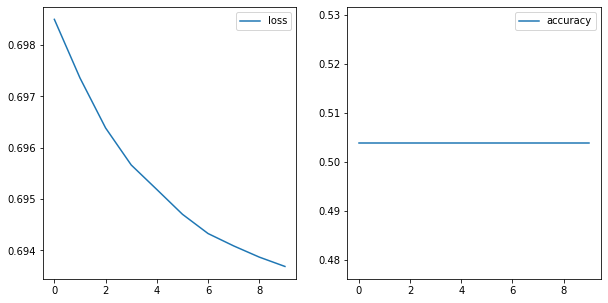

In [12]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [13]:
X_pure_train.shape[0]

1149

In [22]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 1s 8ms/step - loss: 0.6929 - accuracy: 0.5030
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.5074
Epoch 3/100
36/36 [==============================] - 0s 11ms/step - loss: 0.6898 - accuracy: 0.5152
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6886 - accuracy: 0.5213
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.5274
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6873 - accuracy: 0.5457
Epoch 7/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.5283
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6863 - accuracy: 0.5735
Epoch 9/100
36/36 [==============================] - 0s 9ms/step - loss: 0.6859 - accuracy: 0.5614
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6854 - accuracy: 0.5648
Epoch 1

36/36 [==============================] - 0s 9ms/step - loss: 0.6368 - accuracy: 0.8285
Epoch 80/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6355 - accuracy: 0.8225
Epoch 81/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6338 - accuracy: 0.8259
Epoch 82/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6323 - accuracy: 0.8225
Epoch 83/100
36/36 [==============================] - 0s 6ms/step - loss: 0.6308 - accuracy: 0.8233
Epoch 84/100
36/36 [==============================] - 0s 11ms/step - loss: 0.6291 - accuracy: 0.8312 0s - loss: 0.6329 - accura
Epoch 85/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6274 - accuracy: 0.8225
Epoch 86/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6256 - accuracy: 0.8355
Epoch 87/100
36/36 [==============================] - 0s 7ms/step - loss: 0.6240 - accuracy: 0.8268
Epoch 88/100
36/36 [==============================] - 0s 8ms/step - loss: 0.6222 - ac

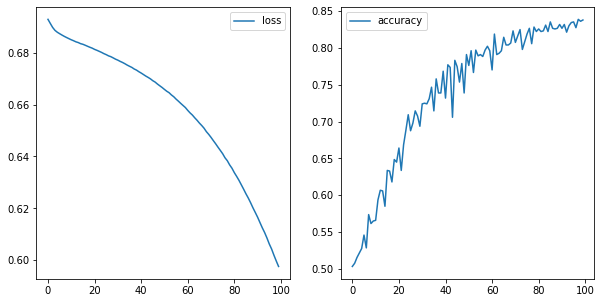

In [24]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0163 - accuracy: 0.5065
Epoch 2/30
115/115 [==============================] - 1s 6ms/step - loss: 0.8930 - accuracy: 0.5213: 0s - loss: 0.9824 
Epoch 3/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0173 - accuracy: 0.4909
Epoch 4/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0731 - accuracy: 0.4874: 1s - loss:
Epoch 5/30
115/115 [==============================] - 1s 7ms/step - loss: 0.9809 - accuracy: 0.4909
Epoch 6/30
115/115 [==============================] - 1s 7ms/step - loss: 1.0019 - accuracy: 0.4978
Epoch 7/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0109 - accuracy: 0.4935
Epoch 8/30
115/115 [==============================] - 1s 6ms/step - loss: 0.9896 - accuracy: 0.4961
Epoch 9/30
115/115 [==============================] - 1s 6ms/step - loss: 1.0202 - accuracy: 0.4935: 0s - loss: 1.0310 - accura
Epoch 10/30
115/115 [===================

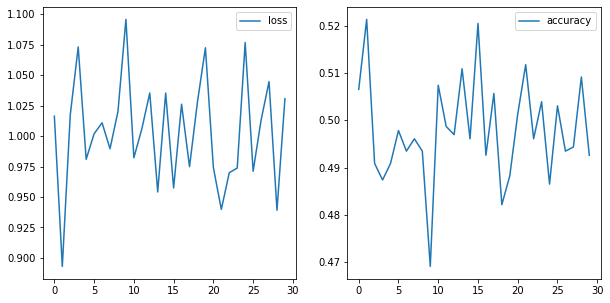

In [16]:
model = Sequential()

# sgd = SGD(learning_rate=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(learning_rate=9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

In [77]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [78]:
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)

Epoch 1/30
115/115 [==============================] - 2s 11ms/step - loss: 0.6158 - accuracy: 0.7415 - val_loss: 0.5292 - val_accuracy: 0.8194
Epoch 2/30
115/115 [==============================] - 1s 9ms/step - loss: 0.4134 - accuracy: 0.8634 - val_loss: 0.3429 - val_accuracy: 0.8819
Epoch 3/30
115/115 [==============================] - 1s 9ms/step - loss: 0.2903 - accuracy: 0.8912 - val_loss: 0.2773 - val_accuracy: 0.8889
Epoch 4/30
115/115 [==============================] - 1s 8ms/step - loss: 0.2418 - accuracy: 0.8982 - val_loss: 0.2475 - val_accuracy: 0.9028
Epoch 5/30
115/115 [==============================] - 1s 7ms/step - loss: 0.2204 - accuracy: 0.9060 - val_loss: 0.2500 - val_accuracy: 0.9028
Epoch 6/30
115/115 [==============================] - 1s 8ms/step - loss: 0.1964 - accuracy: 0.9164 - val_loss: 0.2188 - val_accuracy: 0.9132
Epoch 7/30
115/115 [==============================] - 1s 9ms/step - loss: 0.1798 - accuracy: 0.9164 - val_loss: 0.2049 - val_accuracy: 0.9132
Epoch

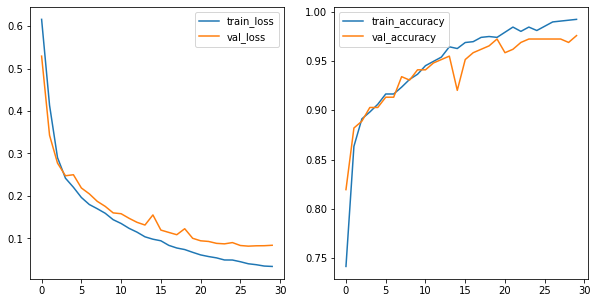

In [79]:
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [80]:
results.history['val_accuracy'][-1]

0.9756944179534912

In [81]:
results.history['accuracy'][-1]

0.9921671152114868

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [25]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x00000278E89E2E80> does not.

In [68]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [75]:

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4,
                           verbose=1,
                           mode='min')


keras_model = KerasClassifier(build_model,
                                          epochs=5,
                                          batch_size=32,
                                          verbose=2,
                              validation_split=.2,
                             callbacks=[early_stop])

In [70]:
type(model)

keras.engine.sequential.Sequential

In [71]:
type(keras_model)

scikeras.wrappers.KerasClassifier

In [76]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/5
23/23 - 1s - loss: 0.6320 - accuracy: 0.6204 - val_loss: 0.6170 - val_accuracy: 0.6250 - 1s/epoch - 45ms/step
Epoch 2/5
23/23 - 0s - loss: 0.5826 - accuracy: 0.6762 - val_loss: 0.5874 - val_accuracy: 0.6902 - 175ms/epoch - 8ms/step
Epoch 00002: early stopping
8/8 - 0s - 91ms/epoch - 11ms/step
Epoch 1/5
23/23 - 1s - loss: 0.6601 - accuracy: 0.6449 - val_loss: 0.6629 - val_accuracy: 0.6576 - 979ms/epoch - 43ms/step
Epoch 2/5
23/23 - 0s - loss: 0.6336 - accuracy: 0.7170 - val_loss: 0.6410 - val_accuracy: 0.6848 - 213ms/epoch - 9ms/step
Epoch 00002: early stopping
8/8 - 0s - 105ms/epoch - 13ms/step
Epoch 1/5
23/23 - 1s - loss: 0.6739 - accuracy: 0.5306 - val_loss: 0.6604 - val_accuracy: 0.6250 - 973ms/epoch - 42ms/step
Epoch 2/5
23/23 - 0s - loss: 0.6513 - accuracy: 0.6313 - val_loss: 0.6350 - val_accuracy: 0.7120 - 314ms/epoch - 14ms/step
Epoch 00002: early stopping
8/8 - 0s - 141ms/epoch - 18ms/step
Epoch 1/5
23/23 - 1s - loss: 0.6954 - accuracy: 0.5088 - val_loss: 0.6927 - val

array([0.70869565, 0.75217391, 0.72608696, 0.50434783, 0.63318777])

## Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

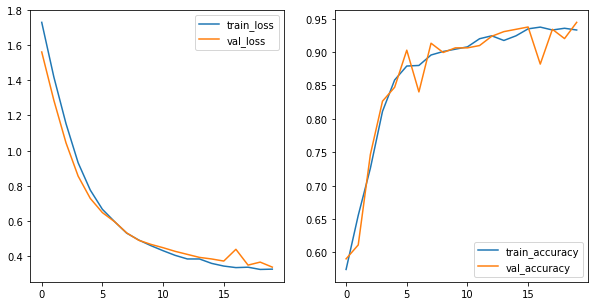

In [32]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

In [33]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 30)                1950      
                                                                 
 dense_43 (Dense)            (None, 20)                620       
                                                                 
 dense_44 (Dense)            (None, 12)                252       
                                                                 
 dense_45 (Dense)            (None, 12)                156       
                                                                 
 dense_46 (Dense)            (None, 12)                156       
                                                                 
 dense_47 (Dense)            (None, 8)                 104       
                                                                 
 dense_48 (Dense)            (None, 4)               

Adding L2 to multiple layers:

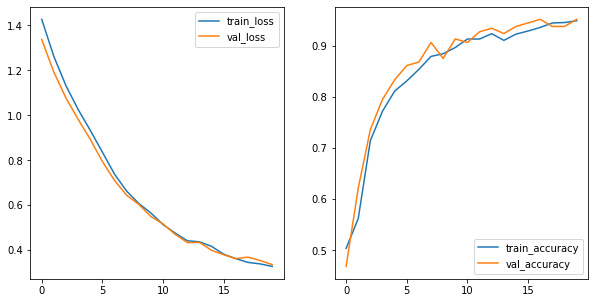

In [36]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

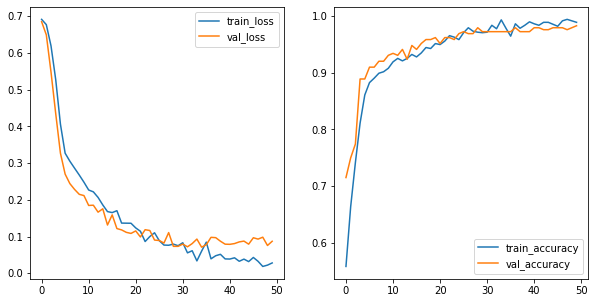

In [37]:
# model.add(Dropout(0.5))

model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(12, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))








train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [38]:
results.history['val_accuracy'][-1]

0.9826388955116272

In [39]:
results.history['accuracy'][-1]

0.9886857867240906

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 1/20
36/36 [==============================] - 1s 15ms/step - loss: 10.6597 - accuracy: 0.5596 - val_loss: 9.0420 - val_accuracy: 0.6493
Epoch 2/20
36/36 [==============================] - ETA: 0s - loss: 7.8586 - accuracy: 0.67 - 0s 10ms/step - loss: 7.7949 - accuracy: 0.6789 - val_loss: 6.5888 - val_accuracy: 0.8299
Epoch 00002: early stopping


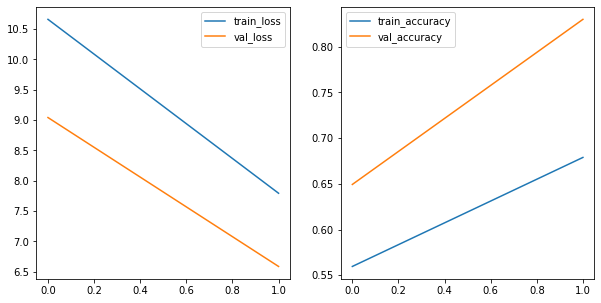

In [40]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu', kernel_regularizer=l2(.5)))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 00047: early stopping


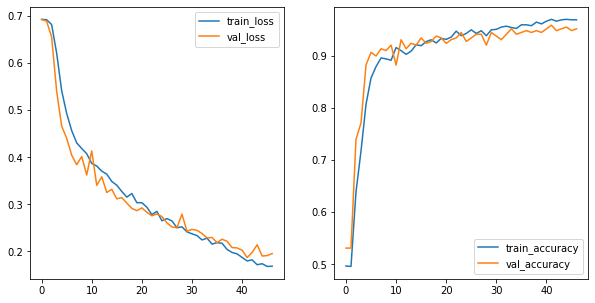

In [41]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, 
                           patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [42]:
results.history['val_accuracy'][-1]

0.9513888955116272

In [43]:
results.history['accuracy'][-1]

0.9686684012413025

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [44]:
digits = load_digits()
X = digits.data
y = digits.target

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [46]:
y_test[0]

6

In [47]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [48]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [49]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision()])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 2s 14ms/step - loss: 2.2837 - accuracy: 0.1532 - precision: 0.0000e+00 - val_loss: 2.1953 - val_accuracy: 0.2188 - val_precision: 0.0000e+00
Epoch 2/50
115/115 [==============================] - 1s 9ms/step - loss: 2.0991 - accuracy: 0.2889 - precision: 1.0000 - val_loss: 2.0033 - val_accuracy: 0.2743 - val_precision: 0.0000e+00
Epoch 3/50
115/115 [==============================] - 1s 10ms/step - loss: 1.8326 - accuracy: 0.3951 - precision: 1.0000 - val_loss: 1.7105 - val_accuracy: 0.4479 - val_precision: 1.0000
Epoch 4/50
115/115 [==============================] - 1s 11ms/step - loss: 1.4806 - accuracy: 0.5544 - precision: 0.9924 - val_loss: 1.3214 - val_accuracy: 0.6493 - val_precision: 0.9836
Epoch 5/50
115/115 [==============================] - 1s 12ms/step - loss: 1.0840 - accuracy: 0.7293 - precision: 0.9901 - val_loss: 0.9467 - val_accuracy: 0.7639 - val_precision: 0.9925
Epoch 6/50
115/115 [==============================] - 

115/115 [==============================] - 1s 10ms/step - loss: 0.1010 - accuracy: 0.9765 - precision: 0.9824 - val_loss: 0.1380 - val_accuracy: 0.9514 - val_precision: 0.9681
Epoch 45/50
115/115 [==============================] - 1s 10ms/step - loss: 0.0991 - accuracy: 0.9774 - precision: 0.9815 - val_loss: 0.1357 - val_accuracy: 0.9583 - val_precision: 0.9684
Epoch 46/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0984 - accuracy: 0.9748 - precision: 0.9781 - val_loss: 0.1362 - val_accuracy: 0.9444 - val_precision: 0.9680
Epoch 47/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0942 - accuracy: 0.9774 - precision: 0.9833 - val_loss: 0.1363 - val_accuracy: 0.9514 - val_precision: 0.9749
Epoch 48/50
115/115 [==============================] - 1s 8ms/step - loss: 0.0920 - accuracy: 0.9748 - precision: 0.9807 - val_loss: 0.1422 - val_accuracy: 0.9514 - val_precision: 0.9647
Epoch 49/50
115/115 [==============================] - 1s 8ms/step - loss: 

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [50]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

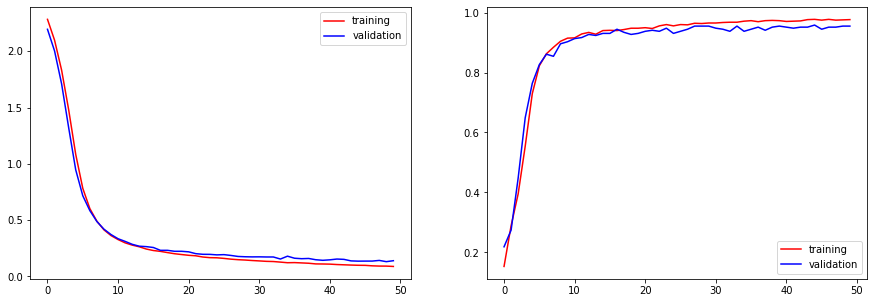

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [52]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

In [56]:
y_hat_test[0]

6

In [55]:
sum(model.predict(X_test)[0])

0.999999985652751

In [57]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[30,  0,  0,  0,  0,  1,  0,  0,  0,  2],
       [ 0, 23,  2,  1,  0,  0,  0,  0,  1,  1],
       [ 0,  1, 31,  0,  0,  0,  0,  0,  1,  0],
       [ 1,  0,  0, 32,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 43,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  1,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 33,  0,  0],
       [ 0,  2,  1,  0,  0,  1,  0,  0, 26,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  0,  2, 35]], dtype=int64)

In [58]:
X_train.shape

(1437, 64)

In [59]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 12)                780       
                                                                 
 dense_99 (Dense)            (None, 8)                 104       
                                                                 
 dense_100 (Dense)           (None, 10)                90        
                                                                 
Total params: 974
Trainable params: 974
Non-trainable params: 0
_________________________________________________________________


Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
